In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from tensorflow.python.keras._impl.keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import operator
from functools import reduce

In [2]:
dataset = pd.read_csv('/home/yaoling/Desktop/hangyan/income_PCA.csv', index_col=[0], parse_dates=[0])
dataset.head(3)

,stat_date,total,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,Comp.8,Comp.9,Comp.10,Comp.11,Comp.12,Comp.13,Comp.14,Comp.15,Comp.16,Comp.17,Comp.18
1,20160101,1.060150e+09,-3.722967,3.995390,-1.427039,-0.342712,0.250247,1.122027,0.187155,1.652488,-0.013872,2.537875,-0.090666,-0.115397,-0.085228,0.078117,0.238693,0.359661,-0.213082,-0.017273
2,20160102,1.070989e+09,-3.977367,3.852914,-1.388795,-0.385318,0.282414,1.105422,0.255038,1.558427,-0.039693,2.252362,0.018632,-0.507548,-0.359579,0.164461,0.175537,0.172459,-0.205090,-0.049985
3,20160103,1.091527e+09,-3.834691,2.950487,-2.036668,-0.270303,0.362256,1.271677,-0.045781,1.253750,0.242025,1.494543,0.392993,-0.250873,0.524982,0.683681,0.021026,0.251070,-0.336074,0.098757


In [3]:
total= dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data.head(7)
train_dataset= dataset.drop((missing_data[missing_data['Total'] > 400]).index,1)


In [4]:
# train_dataset[train_dataset['1'].isnull().values == True]
# train_dataset['1'].describe()
# train_dataset['1'].fillna(1.800267e+07, inplace=True)
# train_dataset[train_dataset['7'].isnull().values == True]
# train_dataset['1'].describe()
# train_dataset['7'].fillna(2.898838e+07, inplace=True)

In [5]:
train_dataset = train_dataset.iloc[:,1:2].values

No handles with labels found to put in legend.


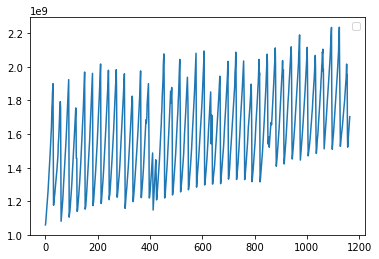

In [6]:
plt.plot(train_dataset)
plt.legend()
plt.show()

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(train_dataset)

In [8]:
def create_train_dataset(dataset, steps):
    X_train, Y_train = [], []
    for i in range(steps, len(dataset)):
        X_train.append(training_set_scaled[i-steps])
        Y_train.append(training_set_scaled[i, 0])
    return np.array(X_train), np.array(Y_train)

In [9]:
split_rate = 0.7
k = int(len(training_set_scaled)*split_rate)
def create_test_dataset(dataset, steps):
    X_test, Y_test = [], []
    for i in range(steps, len(dataset)):
        X_test.append(training_set_scaled[i-steps+k])
        Y_test.append(training_set_scaled[i+k, 0])
    return np.array(X_test), np.array(Y_test)


In [10]:
train_size = int(len(train_dataset) * split_rate)
test_size = len(train_dataset) - train_size
train, test = train_dataset[0:train_size], train_dataset[train_size:len(train_dataset)]


In [11]:
steps = 3
X_train, Y_train = create_train_dataset(train, steps)
X_test, Y_test = create_test_dataset(test, steps)

In [12]:
Y_train.shape,Y_train, X_train.shape,X_train, X_test.shape

((812,), array([0.0408892 , 0.05617543, 0.07220132, 0.0905382 , 0.1116141 ,
        0.12962544, 0.14802131, 0.16986778, 0.1923474 , 0.21545116,
        0.23915345, 0.26453562, 0.28659983, 0.30923999, 0.33338793,
        0.35906942, 0.38673694, 0.4162494 , 0.44266614, 0.46766901,
        0.49236523, 0.54735703, 0.59532681, 0.61734107, 0.66623768,
        0.68850926, 0.71464134, 0.39832747, 0.09951437, 0.10554289,
        0.12350474, 0.13639963, 0.14754487, 0.1599784 , 0.17843164,
        0.19152606, 0.20538597, 0.21935015, 0.23373118, 0.24940223,
        0.26396606, 0.27910452, 0.29702759, 0.31502935, 0.33363866,
        0.35319021, 0.40126978, 0.42264501, 0.44443712, 0.47861151,
        0.50652905, 0.5423109 , 0.59733928, 0.59799007, 0.62380262,
        0.58634591, 0.32783438, 0.01836763, 0.03490404, 0.05175769,
        0.06460422, 0.07991928, 0.0966271 , 0.12101094, 0.14214798,
        0.17281585, 0.19496729, 0.21733445, 0.23767723, 0.25707181,
        0.27968027, 0.30385971, 0.329867

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
regressor = tf.keras.models.Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.Dense(units=1))

regressor.compile(loss='mean_squared_error', optimizer='adam')

regressor.fit(X_train, Y_train, epochs=5, batch_size = 1)


Epoch 1/5
812/812 [==============================] - 6s 7ms/step - loss: 0.0348
Epoch 2/5
812/812 [==============================] - 4s 5ms/step - loss: 0.0280
Epoch 3/5
812/812 [==============================] - 3s 4ms/step - loss: 0.0290
Epoch 4/5
812/812 [==============================] - 4s 4ms/step - loss: 0.0261
Epoch 5/5
812/812 [==============================] - 3s 4ms/step - loss: 0.0267


In [15]:
trainPredict = regressor.predict(X_train)
testPredict = regressor.predict(X_test)
trainPredict.shape, testPredict.shape

((812, 1), (347, 1))

In [16]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([Y_test])


In [17]:
import math
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 180981783.49 RMSE
Test Score: 177644995.14 RMSE


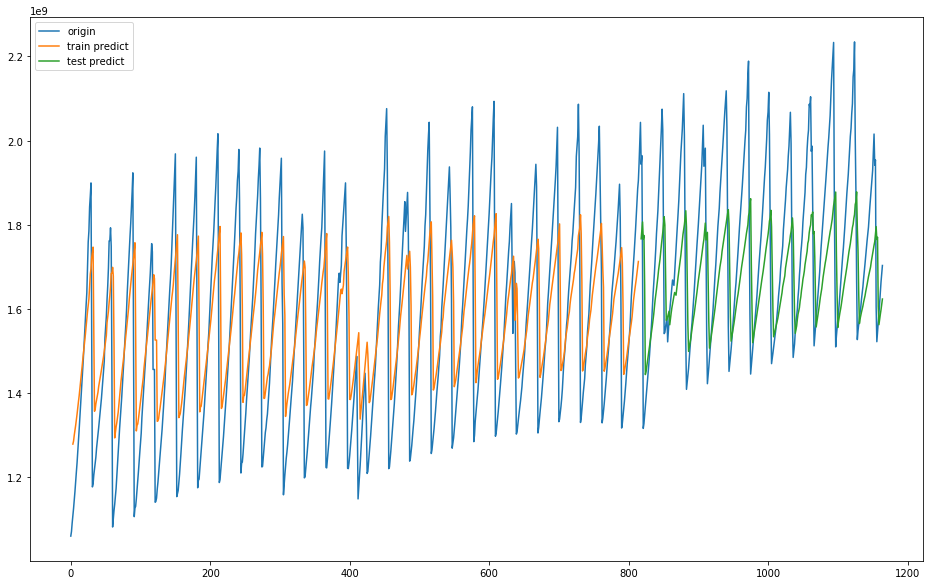

In [18]:
trainPredictPlot = np.empty_like(train_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[steps:len(trainPredict)+steps, :] = trainPredict

testPredictPlot = np.empty_like(train_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(steps*2):len(train_dataset),:] = testPredict

plt.figure(figsize=(16,10))
plt.plot(train_dataset, label = 'origin')
plt.plot(trainPredictPlot, label = 'train predict')
plt.plot(testPredictPlot, label = 'test predict')

plt.legend()
plt.show()


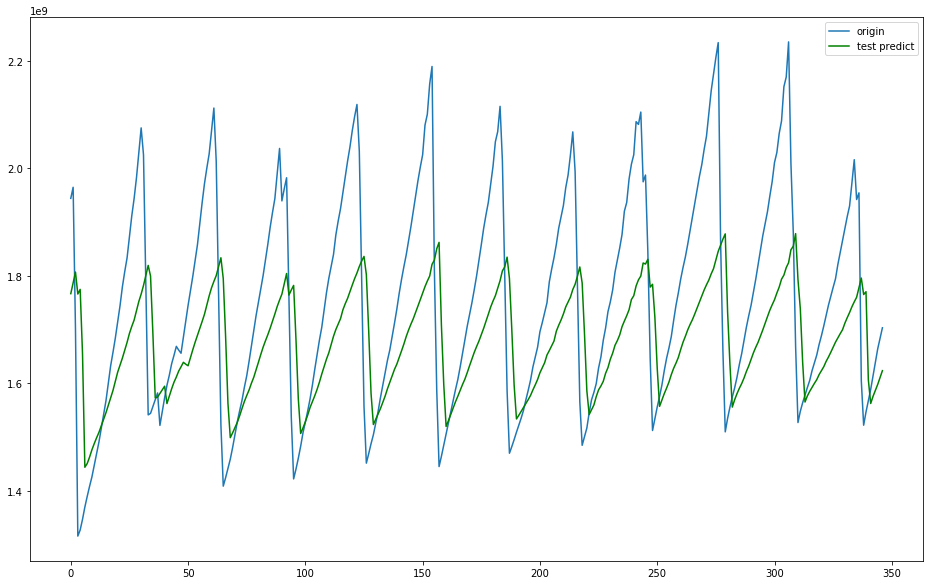

In [19]:
testPredictPlot = np.empty_like(train_dataset[len(trainPredict)+(steps*2):len(train_dataset),:])
testPredictPlot[:, :] = np.nan

plt.figure(figsize=(16,10))
plt.plot(train_dataset[len(trainPredict)+(steps*2):len(train_dataset),:], label = 'origin')
plt.plot(testPredict, label = 'test predict', color='green')

plt.legend()
plt.show()

In [20]:
dataset['evaluation'] = 0
dataset.head(3)

,stat_date,total,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,Comp.8,...,Comp.10,Comp.11,Comp.12,Comp.13,Comp.14,Comp.15,Comp.16,Comp.17,Comp.18,evaluation
1,20160101,1.060150e+09,-3.722967,3.995390,-1.427039,-0.342712,0.250247,1.122027,0.187155,1.652488,...,2.537875,-0.090666,-0.115397,-0.085228,0.078117,0.238693,0.359661,-0.213082,-0.017273,0
2,20160102,1.070989e+09,-3.977367,3.852914,-1.388795,-0.385318,0.282414,1.105422,0.255038,1.558427,...,2.252362,0.018632,-0.507548,-0.359579,0.164461,0.175537,0.172459,-0.205090,-0.049985,0
3,20160103,1.091527e+09,-3.834691,2.950487,-2.036668,-0.270303,0.362256,1.271677,-0.045781,1.253750,...,1.494543,0.392993,-0.250873,0.524982,0.683681,0.021026,0.251070,-0.336074,0.098757,0


In [21]:
trainPredict_flatten = trainPredict.flatten()
testPredict_flatten = testPredict.flatten()

In [22]:
eva_train = []
sum_train = 0
len_train = 0
for i in range(len(trainPredict)):
    evaluation_train = abs((trainPredict[i]/trainY[0][i])-1)
    eva_train.append(evaluation_train)
    sum_train += evaluation_train
    len_train += 1
print('result: ' + str(sum_train / len_train))

result: [0.08941316]


In [23]:
eva_test = []
sum_test = 0
len_test = 0
for i in range(len(testPredict)):
    evaluation_test = abs((testPredict[i]/testY[0][i])-1)
    eva_test.append(evaluation_test)
    sum_test += evaluation_test
    len_test += 1
print('result: ' + str(sum_test / len_test))

result: [0.0800565]


In [24]:
submission_time = pd.DataFrame({
    'time': dataset.stat_date
})

submission_train = pd.DataFrame({
    'train_origin': reduce(operator.add, trainY),
    'train_Predict': trainPredict_flatten,
    'train_evaluation': eva_train
})

submission_test = pd.DataFrame({
    'test_origin': reduce(operator.add, testY),
    'test_predict': testPredict_flatten,
    'test_evaluation': eva_test
})

submission_avg_train = pd.DataFrame({
    'train_evlu_avg': (sum_train / len_train)
})

submission_avg_test = pd.DataFrame({
    'test_evlu_avg': (sum_test / len_test)
})
result = pd.concat([submission_train,submission_avg_train, submission_test, submission_avg_test], axis=1)
result.to_csv('/home/yaoling/Desktop/hangyan/result.csv', index=True)